在回归问题中，我们的目标时预测值（连续的值，而不是类别的离散值），比如价格或者概率。不同于分类问题，是从一个类别列表中选择一个类（比如，一张图片是有评估还是橙子，识别图片中的水果种类）

本实例中使用了经典的Auto MPG数据集，构建一个模型来预测20世纪70年代末和80年代初的汽车燃油效率。为此，我们提供了该时期汽车的一些描述，包括以下属性：气缸，排量，马力和重量。

In [1]:
!pip install -q seaborn

上面这个命令会装seaborn

In [2]:
from __future__ import absolute_import,division,print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow import layers

print(tf.__version__)

1.13.1


## 获取数据

数据集可以从[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/)上得到

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\shanshan\\.keras\\datasets\\auto-mpg.data'

In [4]:
columns_names=['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']
raw_dataset=pd.read_csv(dataset_path,names=columns_names,na_values='?',comment='\t',sep=' ',skipinitialspace=True)
#遇到？也认为是nan值

    names : array-like, default None
        List of column names to use. If file contains no header row, then you
        should explicitly pass header=None. Duplicates in this list will cause
        a ``UserWarning`` to be issued.
        
    skipinitialspace : boolean, default False Skip spaces after delimiter.
    
    comment : str, default None
    Indicates remainder of line should not be parsed. If found at the beginning
    of a line, the line will be ignored altogether. This parameter must be a
    single character. Like empty lines (as long as ``skip_blank_lines=True``),
    fully commented lines are ignored by the parameter `header` but not by
    `skiprows`. For example, if ``comment='#'``, parsing
    ``#empty\na,b,c\n1,2,3`` with ``header=0`` will result in 'a,b,c' being
    treated as the header.
    
    na_values : scalar, str, list-like, or dict, default None
    Additional strings to recognize as NA/NaN. If dict passed, specific
    per-column NA values.  By default the following values are interpreted as
    NaN: '', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan',
    '1.#IND', '1.#QNAN', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan',
    'null'.

In [5]:
dataset=raw_dataset.copy()

In [6]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 清理数据

In [7]:
dataset.isna().sum() #可以看到 Horsepower  这列数据有6个nan值

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
#简单点处理，直接删掉这几个nan行就好
dataset.dropna(inplace=True)

In [9]:
dataset.dtypes  

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

根据教程可知，origin这列虽然是数字，但是真实含义应该是类别，所以使用one-hot进行类别转换

In [10]:
origin=dataset.pop('Origin')  #弹出这列

In [11]:
dataset.shape,type(origin)

((392, 7), pandas.core.series.Series)

In [12]:
dataset['USA']=(origin==1)*1.0
dataset['Europe']=(origin==2)*1.0
dataset['Japan']=(origin==3)*1.0

In [13]:
dataset.tail() #后三列就是one-hot编码形式了

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 划分训练集测试集

In [14]:
train_dataset=dataset.sample(frac=0.8,random_state=0) #随机返回一部分
test_dataset=dataset.drop(train_dataset.index)

## 查看数据（简单的EDA）

快速查看一下训练集中几对数据列的联合分布

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


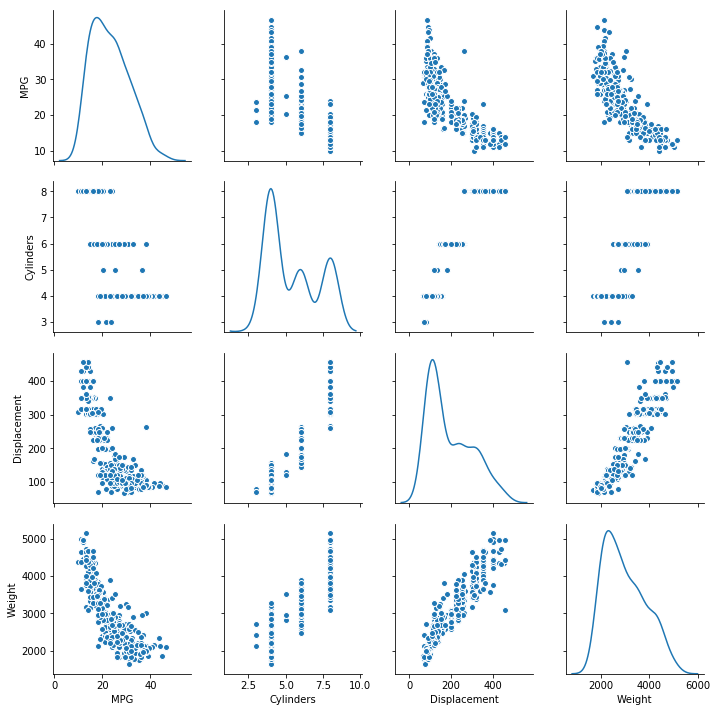

In [15]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']],diag_kind='kde')

这其实就是一个相关性分析，['MPG','Cylinders','Displacement','Weight']  每一个和其他三个包括的关系，同时绘制自己的一个曲线图。

这和之前进行的皮尔逊相关系数分析类似，其实也有重复，所以只取下三角矩阵的图即可，上三角的只是坐标轴变了一下

In [16]:
#查看整体统计指标

train_stats=train_dataset.describe()
train_stats.pop('MPG')  #MPG是最后回归预测的东西
train_stats=train_stats.transpose()  #只是为了看起来更方便，也确实这样看着更方便
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 划分标签和特征

In [17]:
train_labels=train_dataset.pop('MPG')
test_labels=test_dataset.pop('MPG')

## 标准化数据

查看上面的describe()结果，重点关注每个特征之间统计特征差多少个数量级。虽然不经过数据标准化模型也可以收敛，但是这会让训练更难，同时使得最后的模型依赖于选择输入中使用的单位的选择

注意：

虽然上面的统计特征仅仅是训练数据的，但是测试数据集也要进行数据标准化的操作。需要将训练集上进行的操作同样施加到测试集上。

In [18]:
def norm(x):
    return (x-train_stats['mean'])/train_stats['std']
normed_train_data=norm(train_dataset)
normed_test_data=norm(test_dataset)

标准化之后的数据才是我们要用于训练模型的数据。

注意：

之后所有要喂到模型的数据都要使用上述用于标准化输入的统计特征（训练集的mean和std），包括上面的one-hot编码也是。

## 构建模型

In [19]:
def build_model():
    model=keras.Sequential([
        layers.Dense(64,activation=tf.nn.relu,input_shape=[len(train_dataset.keys())]),
        layers.Dense(64,activation=tf.nn.relu),
        layers.Dense(1)  #这是回归问题，最后的结果应该是一个值，直接用来比较的值，而不是类别概率那些的
    ])
    
    optimizer=tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mean_squared_error',
                 optimizer=optimizer,
                 metrics=['mean_absolute_error','mean_squared_error'])
    return model

In [20]:
model=build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.predict(normed_train_data[:10])  #只是看一下结果对不对，看起来这个网络是对的，产生了想要的数据形状和数据格式

array([[ 0.07948958],
       [-0.09592099],
       [ 0.04008975],
       [-0.13572234],
       [-0.49135178],
       [-0.21548626],
       [-0.5304075 ],
       [-0.7601289 ],
       [ 0.02341484],
       [-0.10710469]], dtype=float32)

## 训练模型

In [23]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch%100==0:
            print('')
        else:
            print('.',end='')
#verboser=0，不打印默认的那些信息，而是使用上面这个函数打印，可视化训练进度
EPOCHS=1000
history=model.fit(normed_train_data,train_labels,epochs=EPOCHS,validation_split=0.2,verbose=0,callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................

In [24]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail() #共训练1k次

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.528393,0.989109,2.528393,10.528281,2.473651,10.528281,995
996,2.526443,1.033222,2.526443,10.594904,2.432555,10.594905,996
997,2.449375,0.993970,2.449375,10.233672,2.439812,10.233672,997
998,2.531907,0.969596,2.531907,10.378666,2.457012,10.378666,998
999,2.657875,1.041298,2.657875,10.426678,2.450598,10.426679,999


In [25]:
def plot_history(history):
    hist=pd.DataFrame(history.history)
    hist['epoch']=history.epoch
    
    plt.figure()
    plt.plot(hist['epoch'],hist['mean_absolute_error'],label='Train Error')
    # b  blue solid line default
    plt.plot(hist['epoch'],hist['val_mean_absolute_error'],label='Val Error')
    plt.title('Training and validation mean_absolute_error')
    plt.xlabel('epochs')
    plt.ylabel('Mean Abs Error[MPG]')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.plot(hist['epoch'],hist['mean_squared_error'],label='Train Error')
    # b  blue solid line default
    plt.plot(hist['epoch'],hist['val_mean_squared_error'],label='Val Error')
    plt.title('Training and validation mean_squared_error')
    plt.xlabel('epochs')
    plt.ylabel('Mean Square Error[$MPG^2$]')
    plt.ylim([0,20])
    plt.legend()

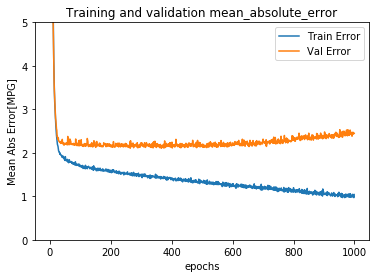

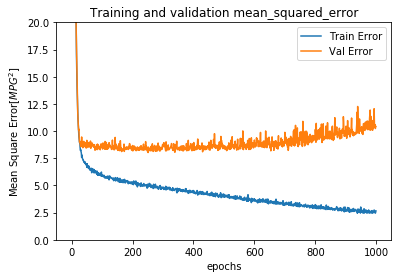

In [26]:
plot_history(history)

上图可以看出在大约100个周期之后，验证集error几乎没有下降。尝试修改下model.fit()使得其可以在验证集score几乎不再提高的时候停止训练。将使用EarlyStopping回调函数，在每个epoch的时候都检测条件。如果模型经过一定数量数据的训练而没有显示出改进，则停止训练

patience: Number of epochs with no improvement
        after which training will be stopped.  也就是如果10个epoch内都没有提高，那就停止训练

In [27]:
model=build_model()

early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history=model.fit(normed_train_data,train_labels,epochs=EPOCHS,validation_split=0.2,verbose=0,callbacks=[early_stop,PrintDot()])


..............................................................................

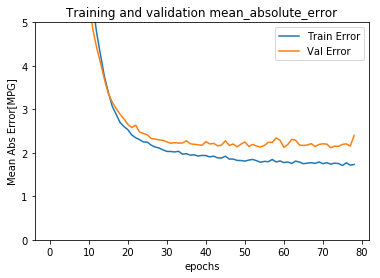

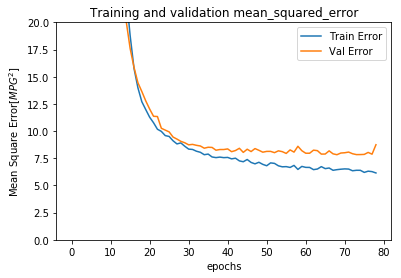

In [28]:
plot_history(history)

## 测试模型

In [29]:
loss,mae,mse=model.evaluate(normed_test_data,test_labels,verbose=0)

In [30]:
loss,mae,mse  #即 均方根误差且1.92，不错了

(5.7384311724931765, 1.8100007, 5.738431)

## 进行预测

In [31]:
test_predictions=model.predict(normed_test_data).flatten()

In [32]:
test_predictions[:10]  #注意，训练集和测试集都是经过标准化处理的，所以预测的是可以直接和测试集比较的

array([15.465239, 10.564091, 10.883307, 22.48692 , 20.247347, 12.445522,
       12.660283, 12.239906, 18.864685, 29.027872], dtype=float32)

    axis('equal')

    changes limits of *x* or *y* axis so that equal increments of *x*
    and *y* have the same length; a circle is circular.:

     axis('square')

    changes the limit ranges (*xmax*-*xmin*) and (*ymax*-*ymin*) of
    the *x* and *y* axes to be the same, and have the same scaling,
    resulting in a square plot.

46.074856630824364


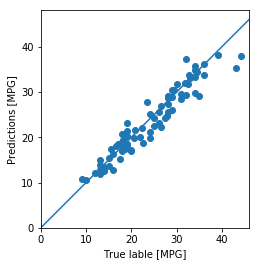

In [39]:
plt.scatter(test_labels,test_predictions)
plt.xlabel('True lable [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')  #这两个参数是对x轴y轴进行一定的约束，是预设的几种参数之一

plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])

_=plt.plot([-100,100],[-100,100])
#除了plot和scatter剩下的都是对x 轴y轴进行调节的代码，使得图像可以显示在画面中央，且画面大小合适

看起来好像预测的还可以，查看一下误差分布

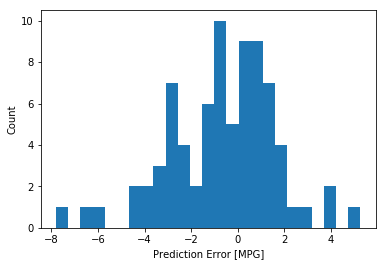

In [40]:
error=test_predictions-test_labels
plt.hist(error,bins=25)
plt.xlabel('Prediction Error [MPG]')
_=plt.ylabel('Count')

可以看到误差分布不是遵从高斯分布的，可以认为一部分原因是因为样本数量太小了

In [41]:
len(test_predictions)  #数据集一共就314个，比较小

78

## 结论

+ Mean Squared Error(MSE)均方差误差 是一种广泛用于回归问题的损失函数（不同的损失函数用于不同的分类问题）
+ 类似的，不同于分类而用于回归问题的评估指标还有，Mean absolute Error(MAE) 
+ 当数字类型的输入特征具有不同的数量级时，需要对每种特征进行缩放使之变成相同的数量级，数值不要差的太大
+ 如果没有很多的训练数据，那么使用只有几个隐藏层的小网络能更好的避免过拟合问题
+ EarlyStopping回调函数是很好的避免过拟合的一种方式